In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.match import NearestNeighborMatch
#this is all gifted students!
df = pd.read_csv("/Users/danielmatten/Desktop/ncerdc_ml/ml-project-structure-demo/data/processed/boundary.csv")
df.drop(columns=['Unnamed: 0'],inplace=True)
masterbuild = pd.read_csv("/Users/danielmatten/Desktop/ncerdc_ml/ml-project-structure-demo/data/processed/masterbuild_master.csv")
masterbuild = masterbuild[['mastid','lea']]

df = df.merge(masterbuild, on='mastid',how='left')
# Step 1: Convert LEA to string and keep only numeric ones
df = df[df['lea'].astype(str).str.match(r'^\d+$')].copy()

# Step 2: Drop students who ever appear in more than one LEA
lea_counts_per_student = df.groupby('mastid')['lea'].nunique()
stable_mastids = lea_counts_per_student[lea_counts_per_student == 1].index

df = df[df['mastid'].isin(stable_mastids)].copy()
df.drop_duplicates(inplace=True, keep='first')

/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_85893/3468282993.py:8: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  masterbuild = pd.read_csv("/Users/danielmatten/Desktop/ncerdc_ml/ml-project-structure-demo/data/processed/masterbuild_master.csv")


In [2]:
expenditures = pd.read_csv("../../data/interim/lea_expenditures.csv")

In [4]:
import pandas as pd

# Step 1: Keep only students with non-zero gifted_grade
gifted_df = df[df['gifted_grade'] > 0].copy()
gifted_df['lea'] = gifted_df['lea'].astype(int)  # Ensure 'lea' is int early

# Step 2: Melt math_ and reading_ scores into long format
score_cols = [col for col in gifted_df.columns if col.startswith('math_') or col.startswith('reading_')]

melted = gifted_df.melt(
    id_vars=['lea', 'gifted_grade'],
    value_vars=score_cols,
    var_name='subject_grade',
    value_name='score'
)
melted['lea'] = melted['lea'].astype(int)

# Step 3: Extract grade number from subject_grade (e.g., 'math_4' → 4)
melted['grade'] = melted['subject_grade'].str.extract(r'_(\d+)').astype(int)

# Step 4: Keep only scores where subject grade >= gifted_grade
melted_filtered = melted[melted['grade'] >= melted['gifted_grade']].copy()

# Step 5: Group by LEA and subject_grade, compute average score
lea_avg_scores = (
    melted_filtered
    .groupby(['lea', 'subject_grade'])['score']
    .mean()
    .reset_index()
)

# Step 6: Pivot to wide format
lea_avg_pivot = lea_avg_scores.pivot(index='lea', columns='subject_grade', values='score').reset_index()
lea_avg_pivot['lea'] = lea_avg_pivot['lea'].astype(int)

# Step 7: Drop early grade columns if needed
lea_avg_pivot.drop(columns=['math_3', 'reading_3'], errors='ignore', inplace=True)

# Step 8: Count number of gifted students per LEA
gifted_counts = gifted_df.groupby('lea').size().reset_index(name='n_gifted')
gifted_counts['lea'] = gifted_counts['lea'].astype(int)

# Step 9: Merge summary table
lea_summary = pd.merge(lea_avg_pivot, gifted_counts, on='lea', how='inner')


lea_summary = lea_summary.merge(expenditures, on='lea',how='left')

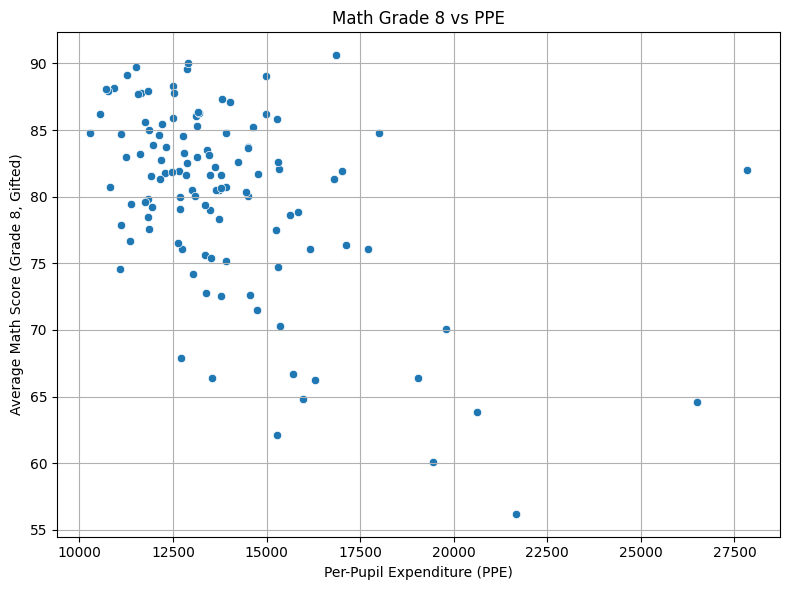

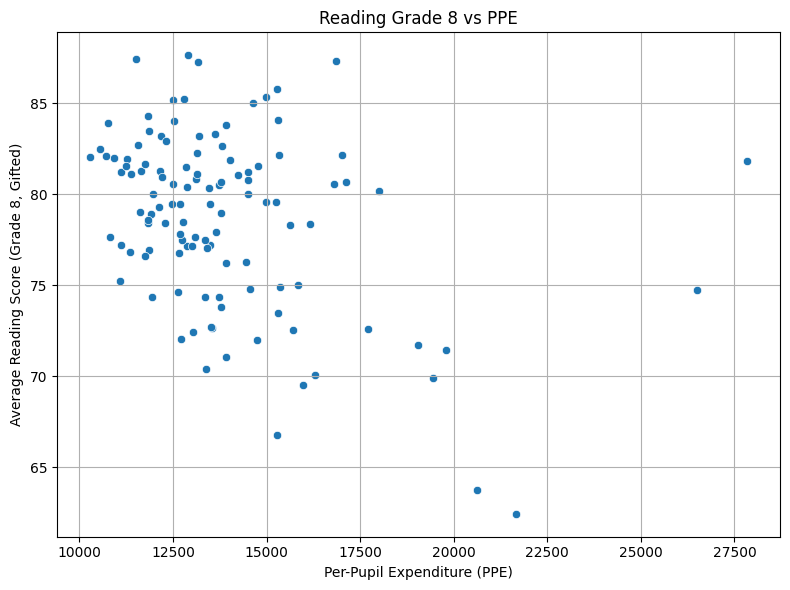

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'ppe' is numeric
# Clean and convert 'ppe' to float
lea_summary['ppe'] = lea_summary['ppe'].str.replace(',', '', regex=False).astype(float)
lea_summary['total'] = lea_summary['total'].str.replace(',', '', regex=False).astype(int)


# Drop rows with missing values for plotting
plot_data = lea_summary.dropna(subset=['math_8', 'reading_8', 'ppe'])

# Plot 1: math_8 vs ppe
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_data, x='ppe', y='math_8')
plt.title('Math Grade 8 vs PPE')
plt.xlabel('Per-Pupil Expenditure (PPE)')
plt.ylabel('Average Math Score (Grade 8, Gifted)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: reading_8 vs ppe
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_data, x='ppe', y='reading_8')
plt.title('Reading Grade 8 vs PPE')
plt.xlabel('Per-Pupil Expenditure (PPE)')
plt.ylabel('Average Reading Score (Grade 8, Gifted)')
plt.grid(True)
plt.tight_layout()
plt.show()


There may be a slight negative relationship between per pupil expenditure and test score % (funding and necessity). However, it's quite fuzzy.

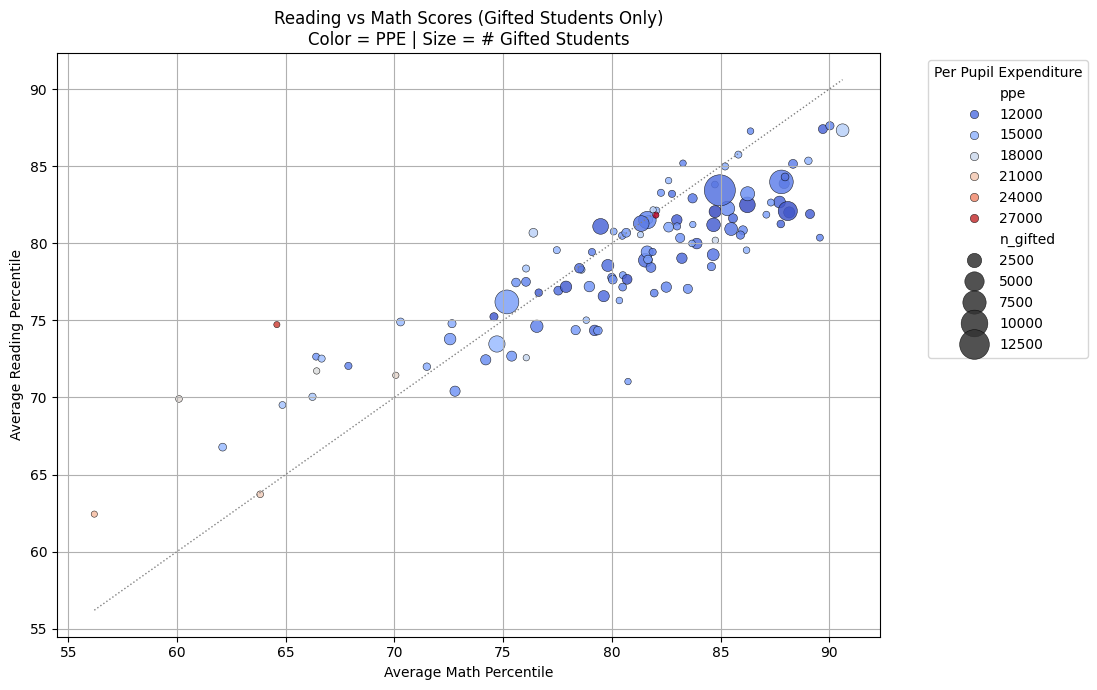

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with needed data
plot_data = lea_summary.dropna(subset=['math_8', 'reading_8', 'ppe', 'n_gifted']).copy()

# Ensure numeric types
plot_data['ppe'] = plot_data['ppe'].astype(float)
plot_data['n_gifted'] = plot_data['n_gifted'].astype(int)

plt.figure(figsize=(9, 7))

# Scatterplot: color = PPE, size = n_gifted
sns.scatterplot(
    data=plot_data,
    x='math_8',
    y='reading_8',
    hue='ppe',
    size='n_gifted',
    palette='coolwarm',       # More contrast than 'viridis'
    sizes=(20, 500),          # Greater size spread
    edgecolor='black',
    alpha=0.85,
    legend='brief'
)

# Regression line
# sns.regplot(
#     data=plot_data,
#     x='math_8',
#     y='reading_8',
#     scatter=False,
#     color='black',
#     line_kws={'linewidth': 1.5, 'linestyle': '--'}
# )

# Diagonal line y = x
min_score = min(plot_data['math_8'].min(), plot_data['reading_8'].min())
max_score = max(plot_data['math_8'].max(), plot_data['reading_8'].max())
plt.plot([min_score, max_score], [min_score, max_score], color='gray', linestyle=':', linewidth=1)

# Labels and formatting
plt.title('Reading vs Math Scores (Gifted Students Only)\nColor = PPE | Size = # Gifted Students')
plt.xlabel('Average Math Percentile')
plt.ylabel('Average Reading Percentile')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Per Pupil Expenditure', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
Most schools score similarily in math and reading. Typically, districts with more gifted students have higher average scores, 
but it's certainly not a perfect relationship. There is clearly a continuum of gifted standards (these are all gifted students,
so schools in the upper right have stricter criteria for giftedness).

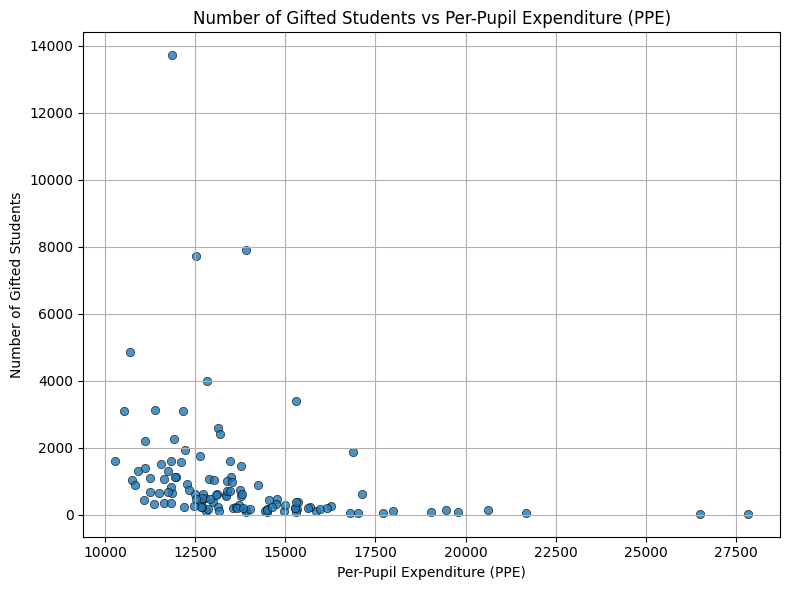

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric types and drop missing data
plot_data = lea_summary.dropna(subset=['ppe', 'n_gifted']).copy()
plot_data['ppe'] = plot_data['ppe'].astype(float)
plot_data['n_gifted'] = plot_data['n_gifted'].astype(int)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_data,
    x='ppe',
    y='n_gifted',
    alpha=0.8,
    edgecolor='black'
)

plt.title('Number of Gifted Students vs Per-Pupil Expenditure (PPE)')
plt.xlabel('Per-Pupil Expenditure (PPE)')
plt.ylabel('Number of Gifted Students')
plt.grid(True)
plt.tight_layout()
plt.show()


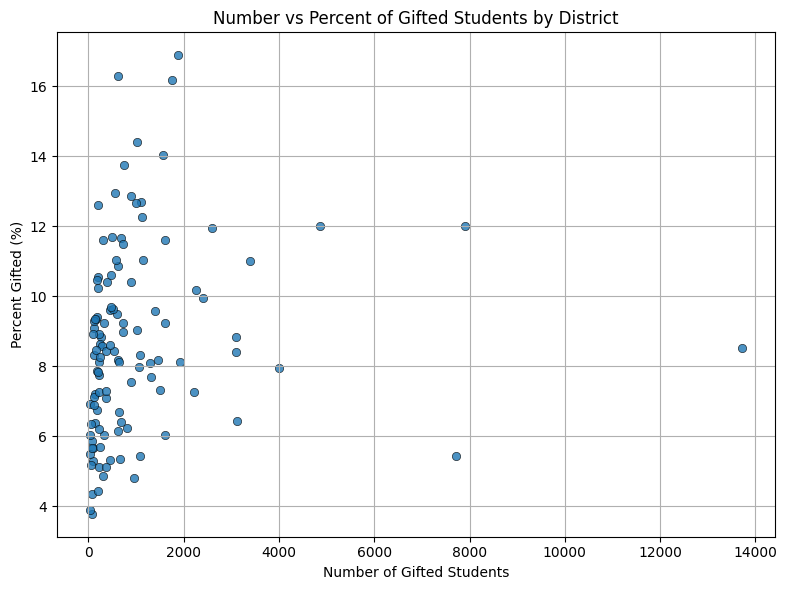

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy and compute percent gifted
plot_data = lea_summary.dropna(subset=['n_gifted', 'total']).copy()
plot_data['total'] = plot_data['total'].astype(int)
plot_data['n_gifted'] = plot_data['n_gifted'].astype(int)

plot_data['percent_gifted'] = (plot_data['n_gifted'] / plot_data['total']) * 100

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_data,
    x='n_gifted',
    y='percent_gifted',
    alpha=0.8,
    edgecolor='black'
)

plt.title('Number vs Percent of Gifted Students by District')
plt.xlabel('Number of Gifted Students')
plt.ylabel('Percent Gifted (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


Quite the range here!